In [1]:
import pickle
import zlib
import numpy as np
import matplotlib.pyplot as plt
import torch
from itertools import combinations_with_replacement

In [2]:
with open('data/train.pickle', 'rb') as f:
    trainset = pickle.loads(zlib.decompress(f.read()))
with open('data/test.pickle', 'rb') as f:
    testset = pickle.loads(zlib.decompress(f.read()))

trainset = torch.tensor(trainset, dtype=torch.float32)

X = trainset[:,0]
Y = trainset[:,1]
print("X:", X.mean(), X.std())
print("Y:", Y.mean(), Y.std())

X: tensor(0.4994) tensor(0.5000)
Y: tensor(0.1256) tensor(2.6320)


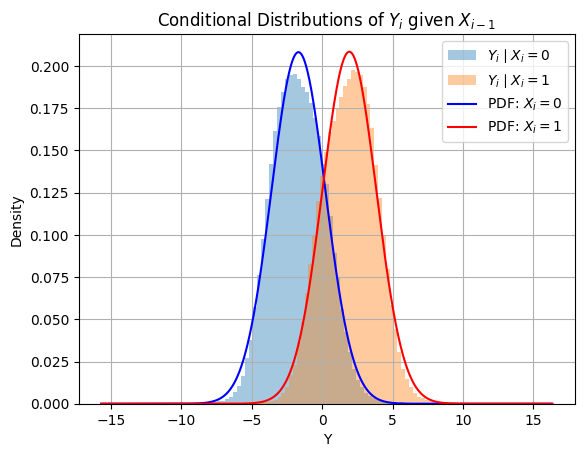

Y given X=0: Mean: tensor(-1.6784) Std: tensor(1.9157)
Y given X=1: Mean: tensor(1.9338) Std: tensor(1.9134)


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

shift = -1  # Shift to align X_{i-1} with Y_i
X_shifted = np.roll(X, shift, axis=1)

# Extract values
y_given_x0 = Y[X_shifted == 0]
y_given_x1 = Y[X_shifted == 1]

# Estimate parameters
mu_0, std_0 = y_given_x0.mean(), y_given_x0.std()
mu_1, std_1 = y_given_x1.mean(), y_given_x1.std()

# Plot histograms
plt.hist(y_given_x0, bins=100, density=True, alpha=0.4, label='$Y_i \mid X_i=0$')
plt.hist(y_given_x1, bins=100, density=True, alpha=0.4, label='$Y_i \mid X_i=1$')

# Create x-axis range for PDF curves
x_range = np.linspace(min(Y.min(), -10), max(Y.max(), 10), 1000)

# Plot the Gaussian PDFs
plt.plot(x_range, norm.pdf(x_range, mu_0, std_0), 'b-', label='PDF: $X_i=0$')
plt.plot(x_range, norm.pdf(x_range, mu_1, std_1), 'r-', label='PDF: $X_i=1$')

plt.legend()
plt.title("Conditional Distributions of $Y_i$ given $X_{i"+("+" if shift>=0 else "")+str(shift)+"}$")
plt.xlabel("Y")
plt.ylabel("Density")
plt.grid()
plt.show()

# Print statistics
print("Y given X=0: Mean:", mu_0, "Std:", std_0)
print("Y given X=1: Mean:", mu_1, "Std:", std_1)


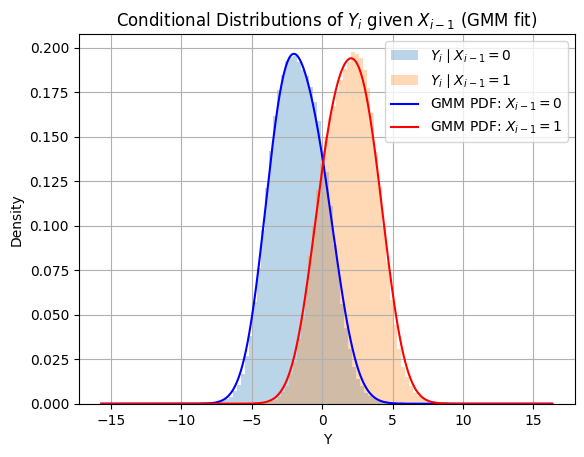


GMM parameters for X_{i-1} = 0:
  Component 1: weight = 0.5302, mean = -2.8003, std = 1.4538
  Component 2: weight = 0.4698, mean = -0.4123, std = 1.5501

GMM parameters for X_{i-1} = 1:
  Component 1: weight = 0.5369, mean = 3.0464, std = 1.4975
  Component 2: weight = 0.4631, mean = 0.6438, std = 1.4853


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

shift = -1  # Shift to align X_{i-1} with Y_i

def print_gmm_params(label, gmm):
    means = gmm.means_.flatten()
    covs = gmm.covariances_.flatten()
    stds = np.sqrt(covs)
    weights = gmm.weights_.flatten()

    print(f"\nGMM parameters for {label}:")
    for i, (w, mu, std) in enumerate(zip(weights, means, stds)):
        print(f"  Component {i+1}: weight = {w:.4f}, mean = {mu:.4f}, std = {std:.4f}")

# Shift X by +1 to align X_{i-1} with Y_i
X_shifted = np.roll(X, shift, axis=1)

# Extract values of Y where shifted X is 0 or 1
y_given_x0 = Y[X_shifted == 0].cpu().numpy().reshape(-1, 1)
y_given_x1 = Y[X_shifted == 1].cpu().numpy().reshape(-1, 1)

# Fit GMMs with 2 components (can be tuned)
gmm_0 = GaussianMixture(n_components=2, random_state=0).fit(y_given_x0)
gmm_1 = GaussianMixture(n_components=2, random_state=0).fit(y_given_x1)

# Create x-axis range for PDF curves
x_range = np.linspace(min(Y.min(), -10), max(Y.max(), 10), 1000).reshape(-1, 1)

# Evaluate GMM densities
pdf_0 = np.exp(gmm_0.score_samples(x_range))
pdf_1 = np.exp(gmm_1.score_samples(x_range))

# Plot histograms
plt.hist(y_given_x0, bins=100, density=True, alpha=0.3, label='$Y_i \mid X_{i-1}=0$')
plt.hist(y_given_x1, bins=100, density=True, alpha=0.3, label='$Y_i \mid X_{i-1}=1$')

# Plot GMM PDFs
plt.plot(x_range, pdf_0, 'b-', label='GMM PDF: $X_{i-1}=0$')
plt.plot(x_range, pdf_1, 'r-', label='GMM PDF: $X_{i-1}=1$')

plt.legend()
plt.title("Conditional Distributions of $Y_i$ given $X_{i-1}$ (GMM fit)")
plt.xlabel("Y")
plt.ylabel("Density")
plt.grid()
plt.show()

# Print parameters for both GMMs
print_gmm_params("X_{i-1} = 0", gmm_0)
print_gmm_params("X_{i-1} = 1", gmm_1)

In [38]:
from sympy import symbols, exp, sqrt, pi, simplify, Eq, pprint

def generate_map_decision_rule(gmm0, gmm1):
    y = symbols('y')

    def gmm_expr(gmm):
        expr = 0
        for w, mu, std in gmm:
            gauss = (w / (sqrt(2 * pi) * std)) * exp(- (y - mu)**2 / (2 * std**2))
            expr += gauss
        return simplify(expr)

    p0 = gmm_expr(gmm0)
    p1 = gmm_expr(gmm1)

    print("MAP Decision Rule (equal priors):")
    print()
    pprint(Eq(p0, p1), use_unicode=True)
    print()
    print("Predict class 0 if the left side > right side, otherwise class 1.")


gmm0 = [
    (0.4829, -0.5727, 1.5014),
    (0.5171,  3.0671, 1.4827)
]

gmm1 = [
    (0.4991,  0.7522, 1.5532),
    (0.5009, -2.8672, 1.4366)
]

generate_map_decision_rule(gmm0, gmm1)


MAP Decision Rule (equal priors):

   ⎛                                      2                                    ↪
   ⎜                   0.227438210280717⋅y                        y⋅(0.2218079 ↪
√2⋅⎝0.149532632870666⋅ℯ                     + 0.0205259474025832⋅ℯ             ↪
────────────────────────────────────────────────────────────────────────────── ↪
                                                                            √π ↪

↪                               ⎞                                              ↪
↪ 87426291⋅y + 1.64921033830205)⎟  -y⋅(0.449246197707008⋅y + 0.254058868798073 ↪
↪                               ⎠⋅ℯ                                            ↪
↪ ──────────────────────────────────────────────────────────────────────────── ↪
↪                                                                              ↪

↪        ⎛                                       2                             ↪
↪ )      ⎜                    0.207259879149915⋅y                       

Text(0.5, 1.0, 'Boxplot of Y grouped by X')

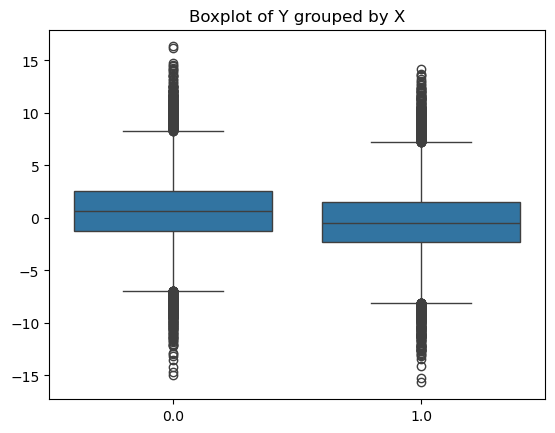

In [33]:
import seaborn as sns

sns.boxplot(x=X.flatten(), y=Y.flatten())
plt.title("Boxplot of Y grouped by X")


Offset	Correlation
-6	0.0124
-5	0.0183
-4	0.0240
-3	-0.2295
-2	0.0285
-1	0.6862
+0	-0.1932
+1	-0.4503
+2	-0.0514
+3	0.1325
+4	-0.0542
+5	-0.0059


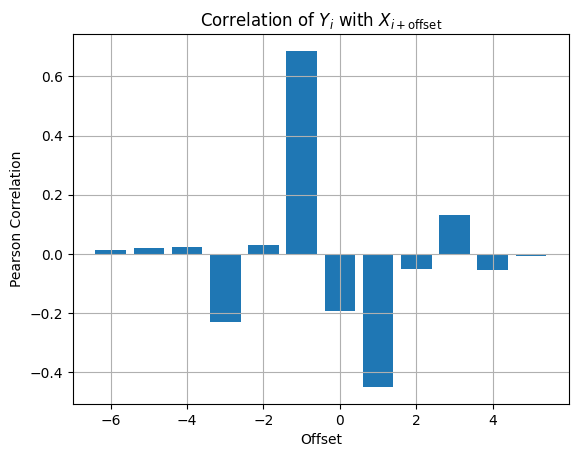

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Estimate cross-correlation
corrs = []
for offset in range(-6, 6):
    x_shifted = np.roll(X, offset, axis=1)
    corr = np.corrcoef(Y.flatten(), x_shifted.flatten())[0, 1]
    corrs.append((offset, corr))

# Print correlations
print("Offset\tCorrelation")
for offset, corr in corrs:
    print(f"{offset:+}\t{corr:.4f}")

# Plot
offsets, values = zip(*corrs)
plt.bar(offsets, values)
plt.title("Correlation of $Y_i$ with $X_{i+\\text{offset}}$")
plt.xlabel("Offset")
plt.ylabel("Pearson Correlation")
plt.grid()
plt.show()


/tmp/ipykernel_3877349/2227527438.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  residuals = y_flat - y_pred
/tmp/ipykernel_3877349/2227527438.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  residuals = y_flat - y_pred
/tmp/ipykernel_3877349/2227527438.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  residuals = y_flat - y_pred
/tmp/ipykernel_3877349/2227527438.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  residuals = y_flat - y_pred
/tmp/ipykernel_3877349/2227527438.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 

Offset	Nonlinear MI
-6	0.0018
-5	0.0020
-4	0.0013
-3	0.0031
-2	0.0044
-1	0.0034
+0	0.0046
+1	0.0042
+2	0.0031
+3	0.0019
+4	0.0029
+5	0.0019


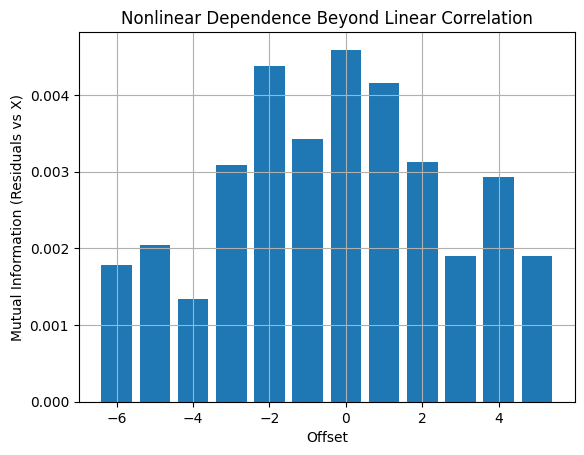

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression

# Store nonlinear-only dependencies
nonlinear_infos = []

for offset in range(-6, 6):
    x_shifted = np.roll(X, offset, axis=1)
    
    x_flat = x_shifted.flatten()[:, None]
    y_flat = Y.flatten()
    
    # Fit linear regression (1st-order)
    linreg = LinearRegression().fit(x_flat, y_flat)
    y_pred = linreg.predict(x_flat)
    
    # Residuals contain the nonlinear part
    residuals = y_flat - y_pred
    
    # Mutual info between residuals and x -> measures non-first-order dependency
    mi = mutual_info_regression(x_flat, residuals, discrete_features=False)[0]
    nonlinear_infos.append((offset, mi))

# Report
print("Offset\tNonlinear MI")
for offset, mi in nonlinear_infos:
    print(f"{offset:+}\t{mi:.4f}")

# Plot
offsets, values = zip(*nonlinear_infos)
plt.bar(offsets, values)
plt.title("Nonlinear Dependence Beyond Linear Correlation")
plt.xlabel("Offset")
plt.ylabel("Mutual Information (Residuals vs X)")
plt.grid()
plt.show()


Offset	Mean Corr	Std Dev
-6	-0.0003		0.0293
-5	-0.0065		0.0329
-4	-0.0551		0.0301
-3	0.1372		0.0344
-2	-0.0522		0.0321
-1	-0.4641		0.0497
+0	-0.1975		0.0338
+1	0.7069		0.0610
+2	0.0297		0.0301
+3	-0.2380		0.0392
+4	0.0241		0.0318
+5	0.0192		0.0308


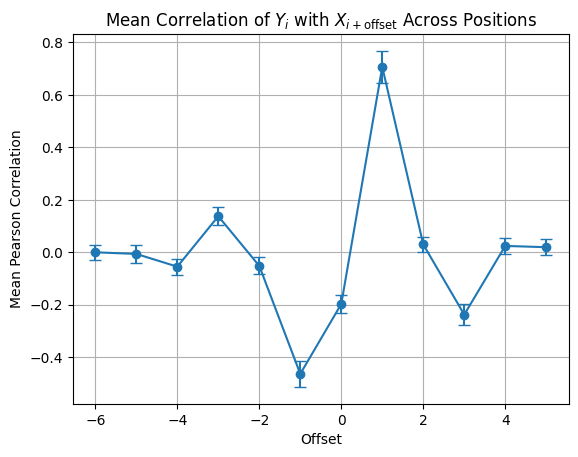

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
offset_range = range(-6, 6)
positions = np.arange(100, 412)  # Exclude borders to allow offsets

# Collect correlations per offset
mean_corrs = []
std_corrs = []

for offset in offset_range:
    local_corrs = []
    for i in positions:
        x_idx = i + offset
        if x_idx < 0 or x_idx >= X.shape[1]:
            continue  # Skip invalid positions due to offset

        x_vals = X[:, x_idx]
        y_vals = Y[:, i]
        corr = np.corrcoef(x_vals, y_vals)[0, 1]
        local_corrs.append(corr)

    local_corrs = np.array(local_corrs)
    mean_corrs.append((offset, np.mean(local_corrs)))
    std_corrs.append(np.std(local_corrs))

# Print mean correlations
print("Offset\tMean Corr\tStd Dev")
for (offset, mean_corr), std in zip(mean_corrs, std_corrs):
    print(f"{offset:+}\t{mean_corr:.4f}\t\t{std:.4f}")

# Plot with error bars
offsets, values = zip(*mean_corrs)
plt.errorbar(offsets, values, yerr=std_corrs, fmt='o-', capsize=4)
plt.title("Mean Correlation of $Y_i$ with $X_{i+\\text{offset}}$ Across Positions")
plt.xlabel("Offset")
plt.ylabel("Mean Pearson Correlation")
plt.grid()
plt.show()


In [10]:
# Define local patterns and search across positions
def pattern_match_distribution(x_pattern, x_data, y_data):
    matches = []
    for i in range(512 - len(x_pattern)):
        x_window = x_data[:, i:i+len(x_pattern)]
        match = (x_window == x_pattern).all(dim=1)
        if match.sum() > 0:
            y_window = y_data[match, i:i+len(x_pattern)]
            matches.append(y_window)
    return torch.cat(matches, dim=0) if matches else None

# Try example pattern [1,0,1]
y_windows = pattern_match_distribution(torch.tensor([1,0,1]), X, Y)
y_windows

tensor([[-2.6605,  1.0281,  3.4243],
        [-2.1517,  0.0096,  4.8593],
        [-2.4638, -0.0215, -2.4715],
        ...,
        [-2.3075,  0.5151,  3.1178],
        [ 0.3823,  3.3950, -1.7606],
        [-4.7300,  2.8861, -1.3514]])